In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

2024-11-04 14:37:08.517648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("/Users/macbookpro/Desktop/neural_nets/lab_6/data/temperature.csv")

In [3]:
df.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   datetime           45253 non-null  object 
 1   Vancouver          44458 non-null  float64
 2   Portland           45252 non-null  float64
 3   San Francisco      44460 non-null  float64
 4   Seattle            45250 non-null  float64
 5   Los Angeles        45250 non-null  float64
 6   San Diego          45252 non-null  float64
 7   Las Vegas          45252 non-null  float64
 8   Phoenix            45250 non-null  float64
 9   Albuquerque        45252 non-null  float64
 10  Denver             45252 non-null  float64
 11  San Antonio        45252 non-null  float64
 12  Dallas             45249 non-null  float64
 13  Houston            45250 non-null  float64
 14  Kansas City        45252 non-null  float64
 15  Minneapolis        45240 non-null  float64
 16  Saint Louis        452

In [5]:
df.columns

Index(['datetime', 'Vancouver', 'Portland', 'San Francisco', 'Seattle',
       'Los Angeles', 'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque',
       'Denver', 'San Antonio', 'Dallas', 'Houston', 'Kansas City',
       'Minneapolis', 'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis',
       'Atlanta', 'Detroit', 'Jacksonville', 'Charlotte', 'Miami',
       'Pittsburgh', 'Toronto', 'Philadelphia', 'New York', 'Montreal',
       'Boston', 'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa',
       'Nahariyya', 'Jerusalem'],
      dtype='object')

In [6]:
df_jerusalem  = df[['datetime', 'Jerusalem']]

In [7]:
df_jerusalem.head()

,datetime,Jerusalem
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,303.5
2,2012-10-01 14:00:00,303.5
3,2012-10-01 15:00:00,303.5
4,2012-10-01 16:00:00,303.5


In [8]:
df_jerusalem.describe()

,Jerusalem
count,44460.000000
mean,293.184253
std,7.093583
min,272.974000
25%,287.524279
50%,292.996000
75%,299.150000
max,317.040000


In [9]:
df_jerusalem.isna().sum()

datetime       0
Jerusalem    793
dtype: int64

In [10]:
df_jerusalem.dropna(inplace=True)

/var/folders/y5/5kc5fqvn2tncnl_868zg4zhr0000gn/T/ipykernel_94582/2681571099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jerusalem.dropna(inplace=True)


In [11]:
df_jerusalem.isna().sum()

datetime     0
Jerusalem    0
dtype: int64

In [12]:
data = df_jerusalem['Jerusalem'].values
scaler = MinMaxScaler(feature_range=(0, 1))
data = data.reshape(-1, 1)
data = scaler.fit_transform(data).flatten()

In [13]:
def get_XY(data, window):
    Y_index = np.arange(window, len(data), window)
    Y = data[Y_index]
    rows_x = len(Y)
    X = data[range(window*rows_x)]
    X = np.reshape(X, (rows_x, window, 1)) 
    return X, Y
window = 20
X, y = get_XY(data, window)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
 test_size = 0.2,
 random_state = 0)

In [15]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units,
    input_shape=input_shape, 
    activation=activation[0],
    return_sequences=False)) 
    model.add(Dense(units=dense_units, 
    activation=activation[1]))
    model.compile(loss='mean_squared_error',
    optimizer='adam',
    metrics=['mean_absolute_error', 
    'mean_squared_error'])
    model.summary()
    return model

In [16]:
model = create_RNN(hidden_units=32,
 dense_units=1,
 input_shape=(window,1), 
 activation=['relu', 'linear'])

/Users/macbookpro/Desktop/neural_nets/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(X_train,
 y_train,
 epochs=20,
 batch_size=32,
 verbose=1,
 validation_split=0.2)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0305 - mean_absolute_error: 0.1328 - mean_squared_error: 0.0305 - val_loss: 0.0018 - val_mean_absolute_error: 0.0349 - val_mean_squared_error: 0.0018
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0338 - mean_squared_error: 0.0019 - val_loss: 0.0013 - val_mean_absolute_error: 0.0255 - val_mean_squared_error: 0.0013
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0270 - mean_squared_error: 0.0015 - val_loss: 0.0012 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0012
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0268 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_absolute_error: 0.0230 - val_mean_squared_error: 0.0011
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0261 - mean_squared_error: 0.0015 - val_loss: 0.0011 - val_mean_absol

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

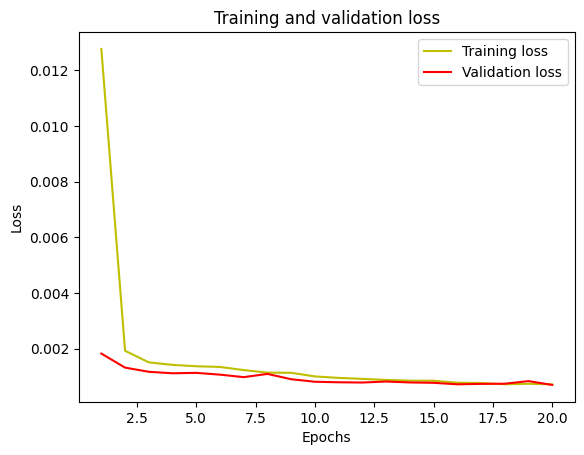

In [19]:
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
def print_error(trainY, testY, train_predict, test_predict): 
    # Error of predictions
    mae = (mean_absolute_error(trainY, train_predict))
    mse = (mean_squared_error(trainY, train_predict))
    # Print RMSE
    print('train MAE: %.10f' % (mae))
    print('train MSE: %.10f' % (mse)) 
    
    # Error of predictions
    mae = (mean_absolute_error(testY, test_predict))
    mse = (mean_squared_error(testY, test_predict))
    # Print RMSE
    print('test MAE: %.10f' % (mae))
    print('test MSE: %.10f' % (mse)) 
    # make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
print_error(y_train, y_test, train_predict, test_predict)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
train MAE: 0.0173255413
train MSE: 0.0006778228
test MAE: 0.0169512207
test MSE: 0.0005828402


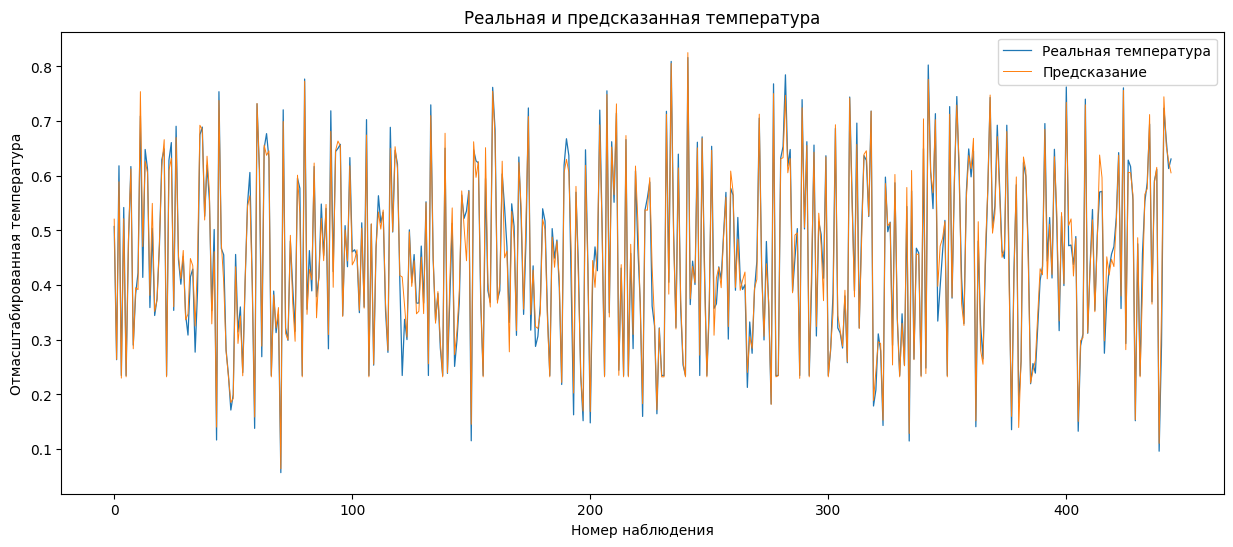

In [22]:
def plot_result(testY, test_predict):
    actual = testY
    predictions = test_predict
    rows = len(actual)
    plt.figure(figsize=(15, 6),dpi=100)
    plt.plot(range(rows), actual, linewidth=0.9)
    plt.plot(range(rows), predictions, linewidth=0.7)
    plt.legend(['Реальная температура', 'Предсказание'])
    plt.xlabel('Номер наблюдения')
    plt.ylabel('Отмасштабированная температура')
    plt.title('Реальная и предсказанная температура')
plot_result(y_test, test_predict)